# Time Series Forecasting Project using Machine Learning
## **Topic: Hourly Energy Consumption**

Making scientific projections based on data with historical time stamps is known as time series forecasting. It entails creating models through historical study, using them to draw conclusions and guide strategic decision-making in the future.

It has tons of practical applications including: weather forecasting, climate forecasting, economic forecasting, healthcare forecasting engineering forecasting, finance forecasting, retail forecasting, business forecasting, environmental studies forecasting, social studies forecasting, and more.

Source: https://www.tableau.com/learn/articles/time-series-forecasting

Types of different time series data:-

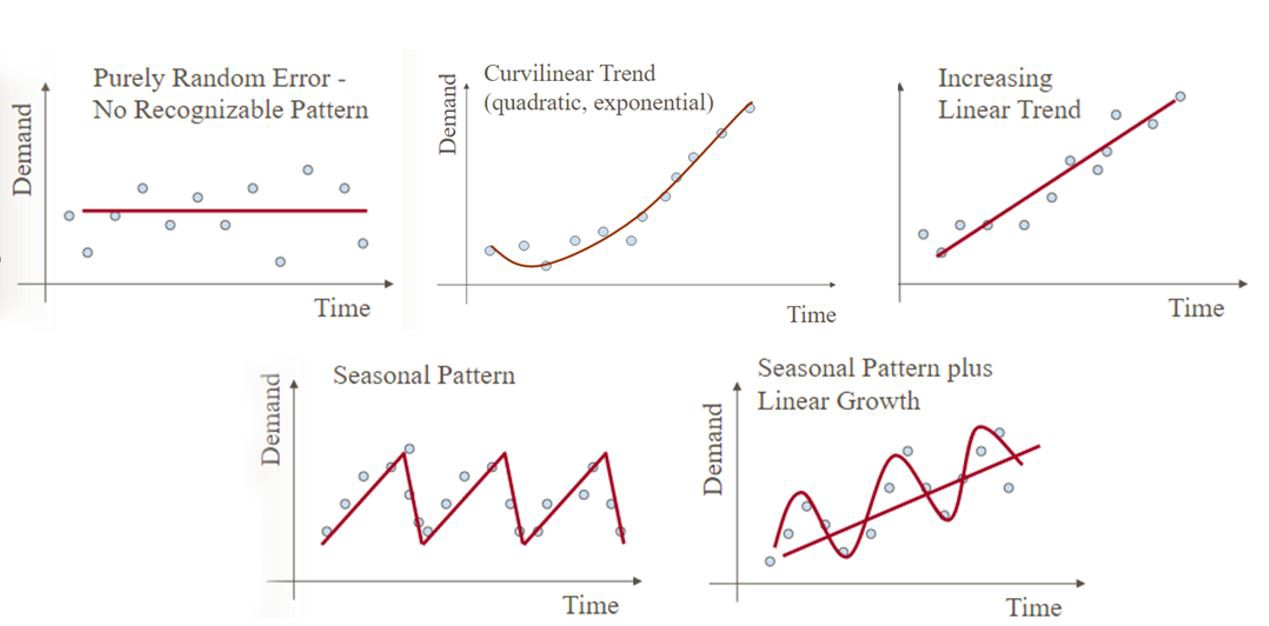

Source: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467 

## 1. Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb  # for modelling
from sklearn.metrics import mean_squared_error

## 2. Loading Data

In [2]:
df = pd.read_csv('/content/PJME_hourly.csv')

df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
# setting index for the data

df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [4]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


## 3. Data Prep

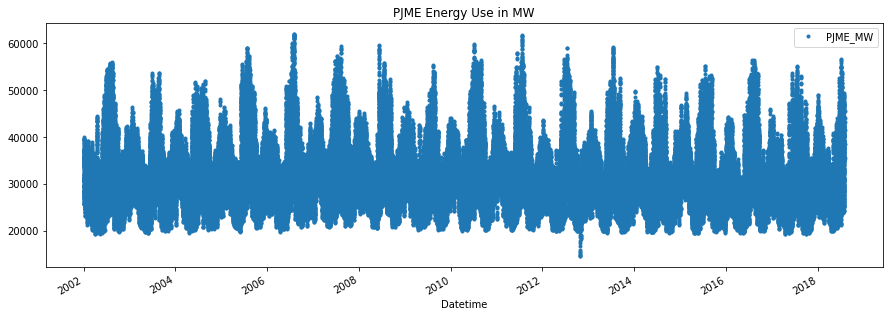

In [5]:
# visualize the data

from seaborn.widgets import color_palette

color_pal = sns.color_palette()

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

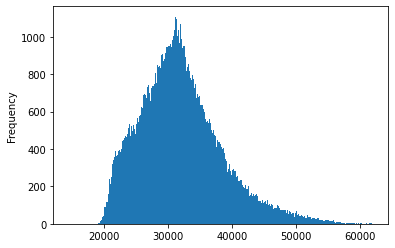

In [6]:
# Outlier Analysis and dealiing with the outliers

df['PJME_MW'].plot(kind='hist', color=color_pal[0], bins=500)

## 4. Train Test Split

In [7]:
# our training data will be everything prior to the year 2015 and testing data will be everything 2015 and after 2015

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

<function matplotlib.pyplot.show(*args, **kw)>

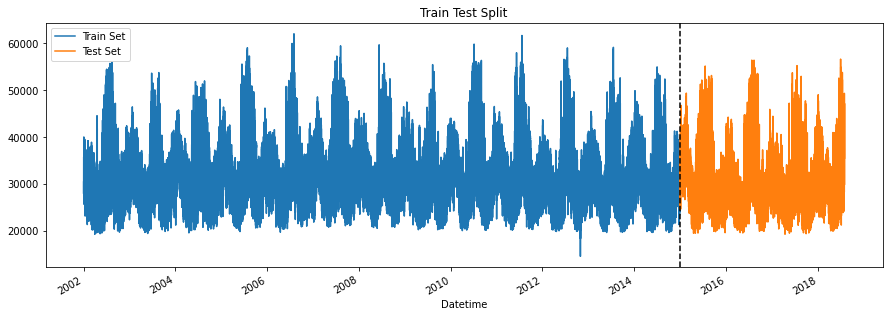

In [8]:
# visualising the training and testing data

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Train Set')
test.plot(ax=ax, label='Test Set', title='Train Test Split')

ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Train Set', 'Test Set'])

plt.show

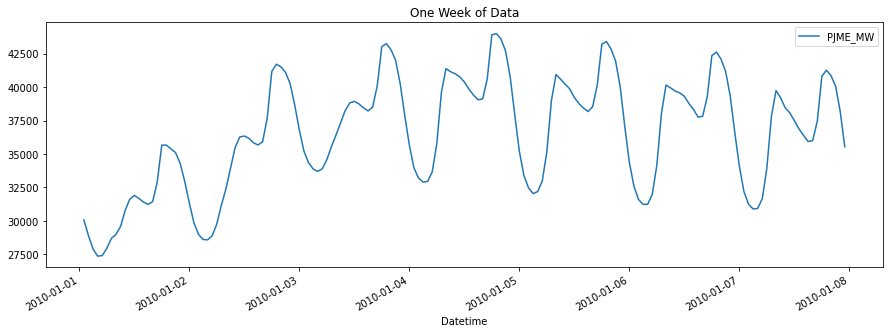

In [9]:
# Exploring and visualising 1 week of data

one_week_data = df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]

one_week_data.plot(figsize=(15,5), title='One Week of Data')
plt.show()

As we can see that there are two peaks everyday which very common in energy consumption. We can also conclude that the graph gets affected by may be day being a weekday or a weekend

## 5. Forecasting Horizon

In [10]:
# we will create a function which help in feature creation and return us a dataframe

def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [11]:
df = create_features(df)

In [12]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


## 6. Visualize the Feature-Target Relationship

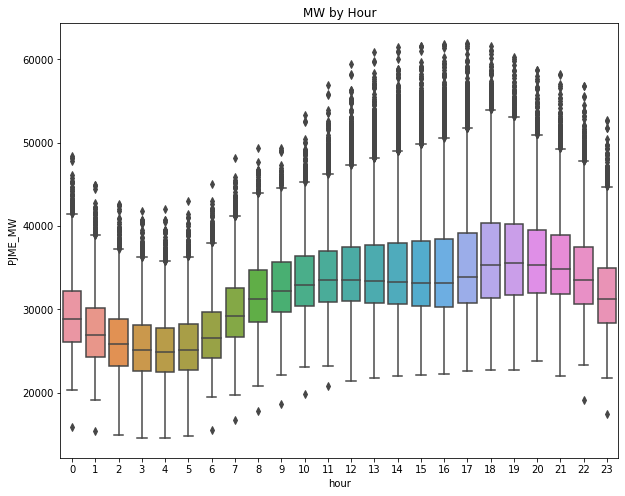

In [13]:
# using boxplot visualisation for feature and target relationship is ideal because it gives you an idea about the distribution of the dataset

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

We can interpret that early in the day there seems to be an dip in energy use and later in the evening, it tends to get higher

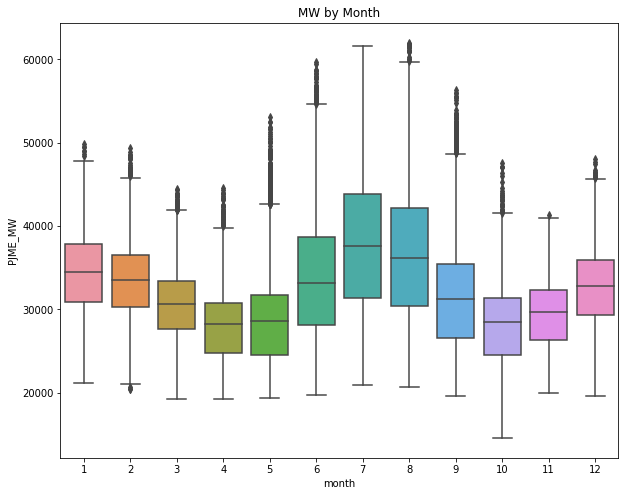

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by Month')
plt.show()

We can interpret that energy is used more during winters (may be because of the heaters). Then we see a peak high during summers due to air conditioners consuming a lot of energy.

## 7. Model Creation

In [15]:
train = create_features(train)
test = create_features(test)

In [16]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
target = 'PJME_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [17]:
# hyperparameters optimizations

params = {
    'booster' : ['gbtree', 'gblinear'],
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
    'objective' : ['reg:squarederror', 'reg:squaredlogerror', 'reg:pseudohubererror', 'reg:logistic', 'reg:linear'],
    'early_stopping_rounds' : [30, 50, 70]
}

In [18]:
reg = xgb.XGBRegressor()

In [19]:
from sklearn.model_selection import RandomizedSearchCV

grid_search = RandomizedSearchCV(reg, param_distributions=params, cv=5, verbose=100)

grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START booster=gbtree, colsample_bytree=0.4, early_stopping_rounds=50, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5, objective=reg:squarederror
[CV 1/5; 1/10] END booster=gbtree, colsample_bytree=0.4, early_stopping_rounds=50, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5, objective=reg:squarederror;, score=0.643 total time=   8.3s
[CV 2/5; 1/10] START booster=gbtree, colsample_bytree=0.4, early_stopping_rounds=50, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5, objective=reg:squarederror
[CV 2/5; 1/10] END booster=gbtree, colsample_bytree=0.4, early_stopping_rounds=50, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5, objective=reg:squarederror;, score=0.718 total time=   7.5s
[CV 3/5; 1/10] START booster=gbtree, colsample_bytree=0.4, early_stopping_rounds=50, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5, objective=reg:squarederr

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 396, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 7

{'objective': 'reg:squarederror',
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'early_stopping_rounds': 30,
 'colsample_bytree': 0.7,
 'booster': 'gbtree'}

In [20]:
print(grid_search.best_params_)

{'objective': 'reg:squarederror', 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'early_stopping_rounds': 30, 'colsample_bytree': 0.7, 'booster': 'gbtree'}


In [28]:
reg = xgb.XGBRegressor(objective= 'reg:squarederror', min_child_weight= 5, max_depth= 3, 
                       learning_rate= 0.1, gamma= 0.3, early_stopping_rounds= 30, 
                       colsample_bytree= 0.7, booster= 'gbtree')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
# we lower our learning rate so that the model doesn't overfit quickly

[0]	validation_0-rmse:29710.4	validation_1-rmse:28762.5
[99]	validation_0-rmse:3081.61	validation_1-rmse:3745.2


XGBRegressor(colsample_bytree=0.7, early_stopping_rounds=30, gamma=0.3,
             min_child_weight=5, objective='reg:squarederror')

## 8. Feature Importance

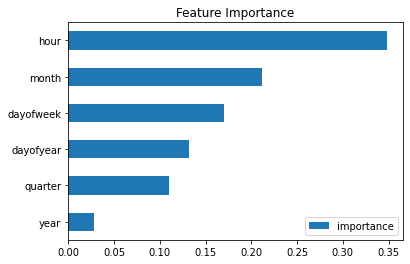

In [33]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'],
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## 9. Forecast on Test

In [34]:
test['Prediction'] = reg.predict(X_test)

df = df.merge(test[['Prediction']], how='left', left_index=True, right_index=True)

df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Prediction_x,Prediction_y,Prediction
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42755.820312,43181.757812,43181.757812
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,42154.523438,43010.808594,43010.808594
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,40812.296875,41252.925781,41252.925781


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'u' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This i

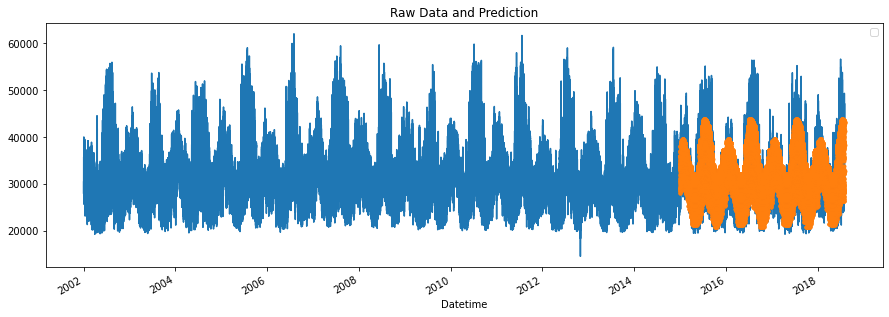

In [35]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['Prediction'].plot(ax=ax, style='.')
plt.legend('Truth Data', 'Prediction')
ax.set_title('Raw Data and Prediction')
plt.show()

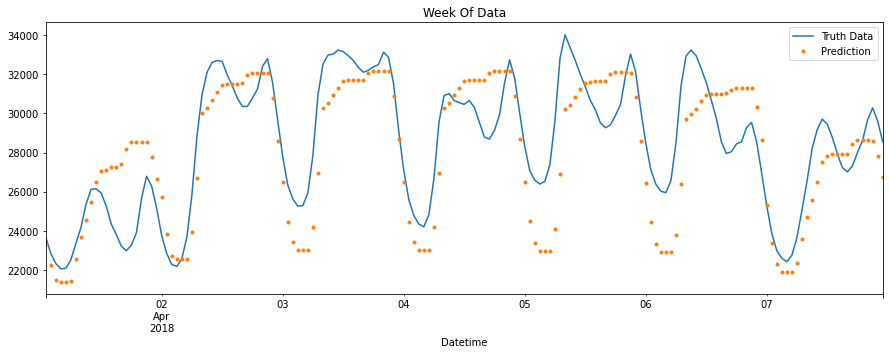

In [36]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['Prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [37]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['Prediction']))
print('RMSE Score on Test set: ',score.round(2))

RMSE Score on Test set:  3745.21


In [38]:
# calculate error
# Look at the worst and best predicted days

test['error'] = np.abs(test[target] - test['Prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12792.234945
2016-08-14    12516.503418
2016-09-10    11840.605306
2016-09-09    11002.320964
2015-02-20    10814.232503
2018-01-06    10520.466146
2018-01-07     9711.873128
2015-02-21     9696.711751
2015-02-16     9658.403076
2017-12-31     9657.422119
Name: error, dtype: float64